<a href="https://colab.research.google.com/github/AleAguirreM/LEA3_Health/blob/main/b_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import joblib ### para cargar array
########Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.ensemble import RandomForestClassifier  ### para analizar modelo
import pandas as pd
from sklearn import tree
import cv2 ### para leer imagenes jpeg
from matplotlib import pyplot as plt #

In [3]:
### cargar bases_procesadas ####
x_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_test.pkl')

In [4]:
#### Escalar ######################
x_train = x_train.astype('float32') ## para poder escalarlo
x_test = x_test.astype('float32') ## para poder escalarlo
x_train /=255 ### escalaro para que quede entre 0 y 1
x_test /=255

###### verificar tamaños
print(x_train.shape)
x_test.shape

(3360, 100, 100, 3)


(840, 100, 100, 3)

In [5]:
np.product(x_train[1].shape) ## cantidad de variables por imagen

30000

In [6]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

##### convertir a 1 d array ############
x_train2 = x_train.reshape(3360,30000)
x_test2 = x_test.reshape(840, 30000)
print(x_train2.shape)
x_test2.shape

(3360, 30000)


(840, 30000)

In [ ]:
############################################################
###############Seleccionar un indicador ################
############################################################

### Precision Tasa de acierto en predichos positivos ( qué porcentaje de personas identificada con neumonía realmente tienen)
### Recall: Tasa de identficación de positivos (de los que tenían neumonía cuantos predije tenían)
### F1_Socre: Combina Precions y recall (promedio entre dos anteriores)
### Acurracy: Porcentaje de acertados
### AUC: detección de positivos vs mala clasificaicón de negativos: porcentaje de los que neumonía que identifico vs los normales que digo que tiene neumonía

############ Analisis problema ###########
#### me interesa recall: de los enfermos que los pueda detectar, sin embargo
#### el problema es que puede generar mucho trabajo porque clasifica a
#### la mayoria como con neumonía, entonces usaremos el AUC que mide la capacidad e clasificación de neumoinía en balance con los noramles mal calsificados


In [7]:
y_train.shape

(3360, 1)

In [8]:
############################################################
################ Probar modelos de redes neuronales #########
############################################################


fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [9]:
##### configura el optimizador y la función para optimizar ##############

fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])


#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))


#########Evaluar el modelo ####################
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)


Epoch 1/10
34/34 [==============================] - 8s 157ms/step - loss: 1.0134 - accuracy: 0.8036 - auc: 0.7318 - recall: 0.4179 - precision: 0.4120 - val_loss: 0.3259 - val_accuracy: 0.8869 - val_auc: 0.9447 - val_recall: 0.3571 - val_precision: 0.9091
Epoch 2/10
34/34 [==============================] - 3s 88ms/step - loss: 0.2531 - accuracy: 0.9152 - auc: 0.9312 - recall: 0.7000 - precision: 0.7701 - val_loss: 0.2456 - val_accuracy: 0.8750 - val_auc: 0.9729 - val_recall: 0.2929 - val_precision: 0.8723
Epoch 3/10
34/34 [==============================] - 3s 86ms/step - loss: 0.1514 - accuracy: 0.9429 - auc: 0.9697 - recall: 0.7482 - precision: 0.8915 - val_loss: 0.6648 - val_accuracy: 0.8357 - val_auc: 0.9349 - val_recall: 0.0214 - val_precision: 0.7500
Epoch 4/10
34/34 [==============================] - 4s 111ms/step - loss: 0.1589 - accuracy: 0.9452 - auc: 0.9647 - recall: 0.7679 - precision: 0.8884 - val_loss: 0.2765 - val_accuracy: 0.8500 - val_auc: 0.9824 - val_recall: 0.1143 - 

In [10]:
x_test.shape

(840, 100, 100, 3)

27/27 [==============================] - 2s 37ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       700
           1       0.95      0.75      0.84       140

    accuracy                           0.95       840
   macro avg       0.95      0.87      0.91       840
weighted avg       0.95      0.95      0.95       840



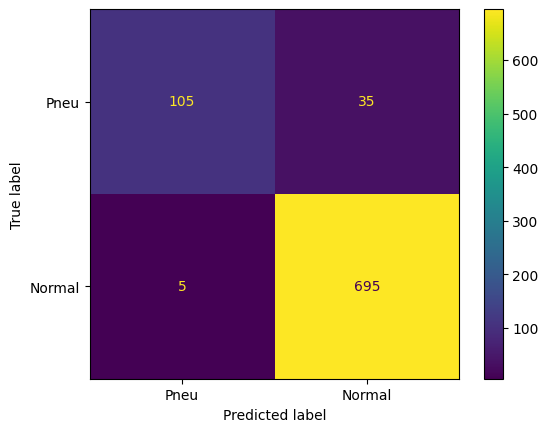

In [11]:
###### matriz de confusión test
pred_test=(fc_model.predict(x_test) > 0.50).astype('int')
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Pneu', 'Normal'])
disp.plot()

print(metrics.classification_report(y_test, pred_test))

In [12]:
#################### exportar red ##############
# guardar modelo
fc_model.save('path_to_my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
#########################################################################################
#########################################################################################
###########Estrategias a usar: regilarization usar una a la vez para ver impacto
#########################################################################################
###############################################################

dropout_rate = 0.3 ## porcentaje de neuronas que elimina

fc_model2=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############


fc_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [15]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model2.fit(x_train, y_train, batch_size=100, epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
34/34 [==============================] - 5s 97ms/step - loss: 1.3806 - auc: 0.6820 - val_loss: 0.3470 - val_auc: 0.9429
Epoch 2/7
34/34 [==============================] - 4s 122ms/step - loss: 0.2464 - auc: 0.9241 - val_loss: 0.2461 - val_auc: 0.9620
Epoch 3/7
34/34 [==============================] - 3s 100ms/step - loss: 0.1950 - auc: 0.9531 - val_loss: 0.3257 - val_auc: 0.9705
Epoch 4/7
34/34 [==============================] - 3s 82ms/step - loss: 0.2003 - auc: 0.9494 - val_loss: 0.2264 - val_auc: 0.9805
Epoch 5/7
34/34 [==============================] - 3s 82ms/step - loss: 0.1814 - auc: 0.9597 - val_loss: 0.2386 - val_auc: 0.9808
Epoch 6/7
34/34 [==============================] - 3s 80ms/step - loss: 0.1518 - auc: 0.9704 - val_loss: 0.2450 - val_auc: 0.9813
Epoch 7/7
34/34 [==============================] - 5s 140ms/step - loss: 0.1505 - auc: 0.9721 - val_loss: 0.1985 - val_auc: 0.9908


In [17]:
####################### aplicar dos regularizaciones L2 y drop out
###Penaliza el tamaño de los pesos, mientras más grande la penalización menores son los valores de los coeficientes

reg_strength = 0.001
###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.3 ## porcentaje de neuronas que utiliza

fc_model3=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############
fc_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [19]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model3.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 8s 173ms/step - loss: 1.8455 - auc: 0.6621 - val_loss: 0.5410 - val_auc: 0.9512
Epoch 2/10
34/34 [==============================] - 4s 110ms/step - loss: 0.5392 - auc: 0.9200 - val_loss: 0.5341 - val_auc: 0.9727
Epoch 3/10
34/34 [==============================] - 4s 108ms/step - loss: 0.4638 - auc: 0.9401 - val_loss: 0.4422 - val_auc: 0.9675
Epoch 4/10
34/34 [==============================] - 6s 171ms/step - loss: 0.4006 - auc: 0.9596 - val_loss: 0.4087 - val_auc: 0.9825
Epoch 5/10
34/34 [==============================] - 4s 113ms/step - loss: 0.3875 - auc: 0.9508 - val_loss: 0.3819 - val_auc: 0.9636
Epoch 6/10
34/34 [==============================] - 4s 108ms/step - loss: 0.3761 - auc: 0.9509 - val_loss: 0.3433 - val_auc: 0.9879
Epoch 7/10
34/34 [==============================] - 5s 152ms/step - loss: 0.3687 - auc: 0.9441 - val_loss: 0.3763 - val_auc: 0.9805
Epoch 8/10
34/34 [==============================] - 4s 119ms/step - loss: 0.

In [20]:
############# Disminuir el numero de neuronas a la mitad

reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.3 ## porcentaje de neuronas que utiliza

fc_model4=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [21]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model4.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 4s 76ms/step - loss: 1.3815 - auc: 0.6114 - val_loss: 0.4967 - val_auc: 0.9305
Epoch 2/10
34/34 [==============================] - 2s 65ms/step - loss: 0.5045 - auc: 0.8361 - val_loss: 0.4350 - val_auc: 0.9514
Epoch 3/10
34/34 [==============================] - 2s 67ms/step - loss: 0.4429 - auc: 0.8847 - val_loss: 0.3950 - val_auc: 0.9730
Epoch 4/10
34/34 [==============================] - 3s 89ms/step - loss: 0.3898 - auc: 0.9180 - val_loss: 0.3354 - val_auc: 0.9806
Epoch 5/10
34/34 [==============================] - 3s 86ms/step - loss: 0.3718 - auc: 0.9218 - val_loss: 0.3245 - val_auc: 0.9790
Epoch 6/10
34/34 [==============================] - 2s 66ms/step - loss: 0.3548 - auc: 0.9257 - val_loss: 0.2936 - val_auc: 0.9798
Epoch 7/10
34/34 [==============================] - 2s 59ms/step - loss: 0.3347 - auc: 0.9357 - val_loss: 0.2946 - val_auc: 0.9841
Epoch 8/10
34/34 [==============================] - 2s 55ms/step - loss: 0.3323 - a

In [22]:
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.2 ## porcentaje de neuronas que utiliza

fc_model5=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [23]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model5.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 7s 116ms/step - loss: 1.1008 - auc: 0.6345 - val_loss: 0.5150 - val_auc: 0.9615
Epoch 2/10
34/34 [==============================] - 2s 49ms/step - loss: 0.4718 - auc: 0.9142 - val_loss: 0.3636 - val_auc: 0.9727
Epoch 3/10
34/34 [==============================] - 2s 49ms/step - loss: 0.4089 - auc: 0.9348 - val_loss: 0.4537 - val_auc: 0.9778
Epoch 4/10
34/34 [==============================] - 2s 53ms/step - loss: 0.3633 - auc: 0.9473 - val_loss: 0.3770 - val_auc: 0.9773
Epoch 5/10
34/34 [==============================] - 3s 84ms/step - loss: 0.3168 - auc: 0.9653 - val_loss: 0.3735 - val_auc: 0.9823
Epoch 6/10
34/34 [==============================] - 3s 76ms/step - loss: 0.3265 - auc: 0.9543 - val_loss: 0.3794 - val_auc: 0.9770
Epoch 7/10
34/34 [==============================] - 2s 48ms/step - loss: 0.3142 - auc: 0.9547 - val_loss: 0.3032 - val_auc: 0.9807
Epoch 8/10
34/34 [==============================] - 2s 50ms/step - loss: 0.2991 - 

In [24]:
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.35 ## porcentaje de neuronas que utiliza

fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])


In [25]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 7s 147ms/step - loss: 2.5512 - auc: 0.6091 - val_loss: 0.5635 - val_auc: 0.9415
Epoch 2/10
34/34 [==============================] - 4s 112ms/step - loss: 0.6283 - auc: 0.8786 - val_loss: 0.5239 - val_auc: 0.9609
Epoch 3/10
34/34 [==============================] - 4s 133ms/step - loss: 0.5582 - auc: 0.9059 - val_loss: 0.5743 - val_auc: 0.9663
Epoch 4/10
34/34 [==============================] - 6s 182ms/step - loss: 0.5023 - auc: 0.9231 - val_loss: 0.4599 - val_auc: 0.9730
Epoch 5/10
34/34 [==============================] - 9s 249ms/step - loss: 0.4446 - auc: 0.9406 - val_loss: 0.3915 - val_auc: 0.9812
Epoch 6/10
34/34 [==============================] - 7s 203ms/step - loss: 0.4076 - auc: 0.9474 - val_loss: 0.5641 - val_auc: 0.9763
Epoch 7/10
34/34 [==============================] - 8s 223ms/step - loss: 0.3869 - auc: 0.9436 - val_loss: 0.3141 - val_auc: 0.9776
Epoch 8/10
34/34 [==============================] - 4s 131ms/step - loss: 0.